In [ ]:
# Function to create FeatureCollection for export
def create_feature_collection(indices, weather):
    def extract_features(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=500,
            maxPixels=1e13
        )
        return ee.Feature(None, stats).set('date', image.date().format('YYYY-MM'))

    indices_features = indices.map(extract_features)
    weather_features = weather.map(extract_features)

    # Merge both collections
    merged_features = indices_features.merge(weather_features)
    return merged_features

# Create final dataset
final_dataset = create_feature_collection(s2_indices, era5_data)

# Export to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=final_dataset,
    description="Punjab_Yield_Data",
    folder="GEE_Exports",
    fileFormat="CSV"
)
export_task.start()

print("Export started! Check your Google Drive (GEE_Exports folder) for the CSV file.")


Export started! Check your Google Drive (GEE_Exports folder) for the CSV file.


In [ ]:
from google.colab import files
files.download("Punjab_Soil_Data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Step 1: Load and Filter the Data
# -----------------------------
# Load the final cleaned dataset
data_path = "/content/cleaned_punjab_yield_data.csv"  # Adjust if needed
df = pd.read_csv(data_path)

# Filter for a specific District and Crop, e.g., "Ludhiana" and "Rice"
df_filtered = df[(df['District'] == 'Ludhiana') & (df['Crop'] == 'Rice')].copy()

# Sort the data chronologically by Year
df_filtered.sort_values(by='Year', inplace=True)
df_filtered.reset_index(drop=True, inplace=True)

print("Filtered and Sorted Data:")
print(df_filtered.head())

# -----------------------------
# Step 2: Windowing (Sequence Creation)
# -----------------------------
# Define the window size (number of past years to use for prediction)
window_size = 3

# Define the feature columns (you can add more if available)
feature_columns = ['NDVI', 'EVI', 'LSWI']
# Define the target column
target_column = 'Yield'

def create_sequences(data, feature_cols, target_col, window):
    """
    Create sequences using a sliding window.

    Parameters:
      data: DataFrame sorted by Year.
      feature_cols: List of feature column names.
      target_col: Target column name.
      window: Window size (number of consecutive years).

    Returns:
      X: Array of shape (samples, window, n_features)
      y: Array of shape (samples,)
    """
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[feature_cols].iloc[i:i+window].values)
        y.append(data[target_col].iloc[i+window])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(df_filtered, feature_columns, target_column, window_size)
print("Sequence shapes --> X:", X.shape, "y:", y.shape)

# -----------------------------
# Step 3: Normalization
# -----------------------------
# Normalize input features (reshape to 2D for scaler, then back to 3D)
n_samples, seq_len, n_features = X.shape
X_flat = X.reshape(-1, n_features)
scaler_X = MinMaxScaler()
X_scaled_flat = scaler_X.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(n_samples, seq_len, n_features)

# Normalize the target variable
y = y.reshape(-1, 1)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

print("After scaling:")
print("X_scaled shape:", X_scaled.shape)
print("y_scaled shape:", y_scaled.shape)

# Optionally, convert the results to variables for model training:
# X_train, y_train = X_scaled, y_scaled


Filtered and Sorted Data:
   District  Year   Yield  Crop  Latitude  Longitude      NDVI       EVI  \
0  Ludhiana  1968  1189.0  Rice    30.901     75.857 -0.018827  0.073436   
1  Ludhiana  1969  1333.0  Rice    30.901     75.857  0.258826 -3.897185   
2  Ludhiana  1970  1505.0  Rice    30.901     75.857  0.319557 -2.196517   
3  Ludhiana  1971  1800.0  Rice    30.901     75.857  0.364074 -2.532743   
4  Ludhiana  1972  2125.0  Rice    30.901     75.857  0.438453 -8.462961   

       LSWI  
0  0.041693  
1  0.094954  
2  0.207873  
3  0.246480  
4  0.187311  
Sequence shapes --> X: (52, 3, 3) y: (52,)
After scaling:
X_scaled shape: (52, 3, 3)
y_scaled shape: (52, 1)


Training samples: 41
Testing samples: 11
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.4532 - val_loss: 0.3854
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3348 - val_loss: 0.3094
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3509 - val_loss: 0.2151
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1858 - val_loss: 0.1131
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1078 - val_loss: 0.0549
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0811 - val_loss: 0.0549
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0838 - val_loss: 0.0523
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0987 - val_loss: 0.0530
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0888 - val_loss: 0.0502
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0770 - val_loss: 0.0499
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0766 - val_loss: 0.0498
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0782 - val_loss: 0.0507
E

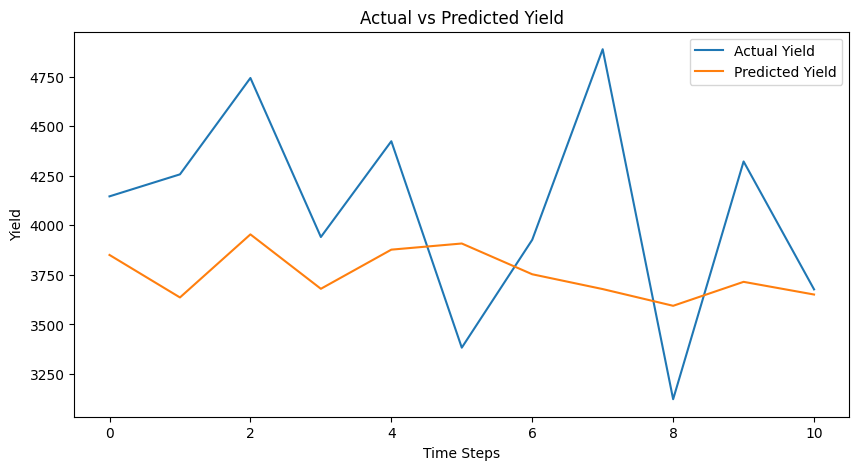

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
Predicted Yield for the new sequence: 4081.0476


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming that your preprocessed data from the previous steps is available as:
# - X_scaled: shape (n_samples, window_size, n_features)
# - y_scaled: shape (n_samples, 1)
# - scaler_y: the MinMaxScaler used for the target variable

# -----------------------------
# Step 1: Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# -----------------------------
# Step 2: Build the LSTM Model
# -----------------------------
model = Sequential()
# First LSTM layer with return_sequences=True for stacking
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(30, activation='relu'))
model.add(Dropout(0.2))
# Final Dense layer for yield prediction
model.add(Dense(1))

# Compile the model using mean squared error loss
model.compile(optimizer='adam', loss='mse')

# -----------------------------
# Step 3: Train the Model
# -----------------------------
# Use early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# -----------------------------
# Step 4: Evaluate the Model
# -----------------------------
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual yields to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# -----------------------------
# Step 5: Plot Predictions vs Actual
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label='Actual Yield')
plt.plot(y_pred, label='Predicted Yield')
plt.xlabel('Time Steps')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield')
plt.legend()
plt.show()

# -----------------------------
# Step 6: Example Prediction for a New Sequence
# -----------------------------
# For demonstration, use the last sequence in your dataset (or create your own sequence)
new_sequence = X_scaled[-1].reshape(1, X_scaled.shape[1], X_scaled.shape[2])
predicted_yield_scaled = model.predict(new_sequence)
predicted_yield = scaler_y.inverse_transform(predicted_yield_scaled)
print("Predicted Yield for the new sequence:", predicted_yield[0][0])


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.save(save_dir + "lstm_yield_model.h5")


In [ ]:
lstm_model = tf.keras.models.load_model(save_dir + "lstm_yield_model.h5")


In [ ]:
lstm_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae', 'mse'])
print("Model recompiled successfully.")


Model recompiled successfully.


In [ ]:
model.save("lstm_yield_model.h5")


In [ ]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the directory in your Google Drive where you want to save the files.
save_dir = "/content/drive/MyDrive/models/"
!mkdir -p {save_dir}  # Create the directory if it doesn't exist

# Save the LSTM model
model.save(save_dir + "lstm_yield_model.h5")
print("LSTM model saved to:", save_dir + "lstm_yield_model.h5")

# Save the feature scaler (scaler_X) using pickle
import pickle
with open(save_dir + "scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)
print("Feature scaler saved to:", save_dir + "scaler_X.pkl")

# Save the target scaler (scaler_y) using pickle
with open(save_dir + "scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)
print("Target scaler saved to:", save_dir + "scaler_y.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LSTM model saved to: /content/drive/MyDrive/models/lstm_yield_model.h5
Feature scaler saved to: /content/drive/MyDrive/models/scaler_X.pkl
Target scaler saved to: /content/drive/MyDrive/models/scaler_y.pkl
